In [ ]:
pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.5/129.5 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 19.9 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Embedding, Reshape, Input, concatenate, Flatten
from tensorflow.keras.models import Model
import keras_tuner as kt

Using TensorFlow backend


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
games = pd.read_csv(r'/content/drive/MyDrive/games.csv')
games.columns.values

Mounted at /content/drive


array(['GAME_DATE_EST', 'GAME_ID', 'GAME_STATUS_TEXT', 'HOME_TEAM_ID',
       'VISITOR_TEAM_ID', 'SEASON', 'TEAM_ID_home', 'PTS_home',
       'FG_PCT_home', 'FT_PCT_home', 'FG3_PCT_home', 'AST_home',
       'REB_home', 'TEAM_ID_away', 'PTS_away', 'FG_PCT_away',
       'FT_PCT_away', 'FG3_PCT_away', 'AST_away', 'REB_away',
       'HOME_TEAM_WINS'], dtype=object)

In [ ]:
#zmiana ID druzyn do prostych wartosci 0 - 29
team_id = games['HOME_TEAM_ID'].unique()
games = games.replace(team_id, np.arange(0,30,1))
games

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,...,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
0,2022-12-22,22200477,Final,0,20,2022,0,126.0,0.484,0.926,...,25.0,46.0,20,117.0,0.478,0.815,0.321,23.0,44.0,1
1,2022-12-22,22200478,Final,1,27,2022,1,120.0,0.488,0.952,...,16.0,40.0,27,112.0,0.561,0.765,0.333,20.0,37.0,1
2,2022-12-21,22200466,Final,2,21,2022,2,114.0,0.482,0.786,...,22.0,37.0,21,106.0,0.470,0.682,0.433,20.0,46.0,1
3,2022-12-21,22200467,Final,3,13,2022,3,113.0,0.441,0.909,...,27.0,49.0,13,93.0,0.392,0.735,0.261,15.0,46.0,1
4,2022-12-21,22200468,Final,4,23,2022,4,108.0,0.429,1.000,...,22.0,47.0,23,110.0,0.500,0.773,0.292,20.0,47.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26646,2014-10-06,11400007,Final,4,0,2014,4,93.0,0.419,0.821,...,24.0,50.0,0,87.0,0.366,0.643,0.375,17.0,43.0,1
26647,2014-10-06,11400004,Final,23,27,2014,23,81.0,0.338,0.719,...,18.0,40.0,27,85.0,0.411,0.636,0.267,17.0,47.0,0
26648,2014-10-06,11400005,Final,19,16,2014,19,98.0,0.448,0.682,...,29.0,45.0,16,95.0,0.387,0.659,0.500,19.0,43.0,1
26649,2014-10-05,11400002,Final,18,11,2014,18,99.0,0.440,0.771,...,21.0,30.0,11,94.0,0.469,0.725,0.385,18.0,45.0,1


In [ ]:
def divide_seasons(season_1, season_2, feature ,pd_games = games):
    result_1 = pd_games[pd_games['SEASON'] == season_1]
    result_2 = pd_games[pd_games['SEASON'] == season_2]
    result = pd.concat([result_1, result_2])
    result = result.loc[: , ~result.columns.isin(['GAME_DATE_EST', 'GAME_ID', 'GAME_STATUS_TEXT', 'TEAM_ID_home', 'TEAM_ID_away', 'SEASON'])]
    X_result_id = result.loc[: , ['HOME_TEAM_ID', 'VISITOR_TEAM_ID']].to_numpy()
    y_result_win = result['HOME_TEAM_WINS'].to_numpy()
    y_result_feat = result[feature].to_numpy()
    return X_result_id, y_result_feat, y_result_win


In [ ]:

#generator do tworzenia wykresow
features = ['PTS_home',
       'FG_PCT_home', 'FT_PCT_home', 'FG3_PCT_home', 'AST_home',
       'REB_home','PTS_away', 'FG_PCT_away',
       'FT_PCT_away','FG3_PCT_away', 'AST_away', 'REB_away',
]


In [ ]:

def generator(lista):
  for number in lista:
    yield number

gen = generator(features)  #/// odkomentowac do tworzenia 1 wykresu, pozniej zakomentowac


In [ ]:

feature = next(gen)
print(feature)

PTS_home


In [ ]:
#zbior treningowy 2017/18 + 2018/19
X_train_id, y_train_feat, y_train_win = divide_seasons(2017, 2018, feature)

#zbior walidacyjny 2019/20   2020/21
X_valid_id, y_valid_feat, y_valid_win = divide_seasons(2019, 2020, feature)       #mniejsza ilosc meczy ze wzgledu na COVID

#zbior testowy - 2021/22 2022/23
X_test_id, y_test_feat, y_test_win  = divide_seasons(2021, 2022, feature)       #roznica w ilosci wynika z niedokonczonego sezonu 2022 (do konca grudnia)

In [ ]:
#model_feat - feature
input_embedding_feat = Input(shape = (2,))
embedding_feat = Embedding(input_dim=30, output_dim=5, input_length=2)(input_embedding_feat)
embedding_feat = Dense(100)(embedding_feat)   #bottleneck layer
embedding_feat = Flatten()(embedding_feat)
output_feat = Dense(1, activation = 'sigmoid')(embedding_feat)

model_feat = Model(input_embedding_feat, output_feat)
model_feat.compile(optimizer = 'adam', loss = 'mse')
model_feat.summary()
r_feat = model_feat.fit(X_train_id, y_train_feat, epochs = 1, validation_data = (X_valid_id, y_valid_feat), verbose = False)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 embedding_1 (Embedding)     (None, 2, 5)              150       
                                                                 
 dense_2 (Dense)             (None, 2, 100)            600       
                                                                 
 flatten_1 (Flatten)         (None, 200)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 201       
                                                                 
Total params: 951 (3.71 KB)
Trainable params: 951 (3.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
plt.plot(r_feat.history['loss'])
plt.plot(r_feat.history['val_loss'])

In [ ]:
#freeze wag model_feat
for layer in model_feat.layers:
    layer.trainable=False
print(output_feat.shape)

#model - win
input_embedding_win = Input(shape = (2,))
embedding_win = Embedding(input_dim=30, output_dim=5, input_length=2)(input_embedding_win)
embedding_win = Flatten()(embedding_win)
print(embedding_win.shape)


merged = concatenate([output_feat, embedding_win])

#zmienic ilosc neuronow
merged = Dense(64, activation = 'relu')(merged)
merged = Dense(64, activation = 'relu')(merged)
###
output = Dense(1, activation = 'sigmoid')(merged)

model_win = Model(inputs = [input_embedding_win, input_embedding_feat], outputs = output)
model_win.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model_win.summary()

(None, 1)
(None, 10)
Model: "model_37"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_25 (InputLayer)       [(None, 2)]                  0         []                            
                                                                                                  
 embedding_24 (Embedding)    (None, 2, 5)                 150       ['input_25[0][0]']            
                                                                                                  
 dense_84 (Dense)            (None, 2, 100)               600       ['embedding_24[0][0]']        
                                                                                                  
 input_26 (InputLayer)       [(None, 2)]                  0         []                            
                                                                      

In [ ]:
r = model_win.fit([X_train_id, X_train_id], y_train_win, epochs = 50, validation_data = ([X_valid_id,X_valid_id] , y_valid_win))

Epoch 1/50
87/87 [==============================] - 3s 18ms/step - loss: 0.6799 - accuracy: 0.5804 - val_loss: 0.6897 - val_accuracy: 0.5410
Epoch 2/50
87/87 [==============================] - 1s 13ms/step - loss: 0.6556 - accuracy: 0.6040 - val_loss: 0.7094 - val_accuracy: 0.5522
Epoch 3/50
87/87 [==============================] - 1s 12ms/step - loss: 0.6164 - accuracy: 0.6692 - val_loss: 0.7381 - val_accuracy: 0.5434
Epoch 4/50
87/87 [==============================] - 1s 10ms/step - loss: 0.6114 - accuracy: 0.6717 - val_loss: 0.7438 - val_accuracy: 0.5357
Epoch 5/50
87/87 [==============================] - 1s 11ms/step - loss: 0.6091 - accuracy: 0.6743 - val_loss: 0.7534 - val_accuracy: 0.5466
Epoch 6/50
87/87 [==============================] - 1s 8ms/step - loss: 0.6088 - accuracy: 0.6667 - val_loss: 0.7550 - val_accuracy: 0.5426
Epoch 7/50
87/87 [==============================] - 1s 7ms/step - loss: 0.6071 - accuracy: 0.6736 - val_loss: 0.7406 - val_accuracy: 0.5293
Epoch 8/50
87/8

In [ ]:
#sprawdzamy model o innej ilosci warstw
"""
merged = concatenate([output_feat, embedding_win])
merged = Dense(64, activation = 'relu')(merged)
#merged = Dense(64, activation = 'relu')(merged)
output = Dense(1, activation = 'sigmoid')(merged)

model_win_2 = Model(inputs = [input_embedding_win, input_embedding_feat], outputs = output)
model_win_2.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model_win_2.summary()
"""

In [ ]:
#r_2 = model_win_2.fit([X_train_id, X_train_id], y_train_win, epochs = 50, validation_data = ([X_valid_id,X_valid_id] , y_valid_win))

"\nfilename_acc = '/content/win_accuracy_plot-' + feature + '.png'\nplt.savefig(filename_acc, format = 'png')\n"

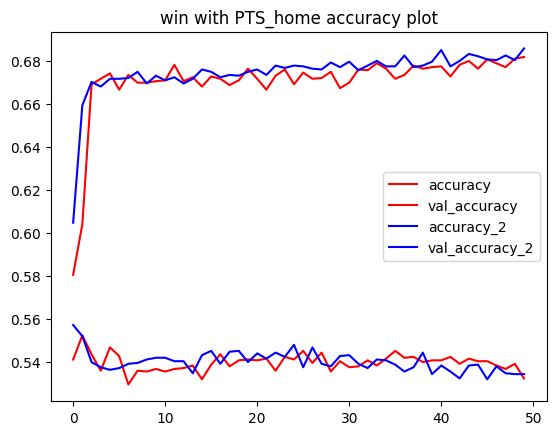

In [ ]:
plt.plot(r.history['accuracy'], label = 'accuracy', color = 'red')
plt.plot(r.history['val_accuracy'], label = 'val_accuracy', color = 'blue')

"""
plt.plot(r_2.history['accuracy'], label = 'accuracy_2', color = 'blue')
plt.plot(r_2.history['val_accuracy'], label = 'val_accuracy_2', color = 'blue')
"""
plt.title('win with ' + feature + ' accuracy plot')
plt.legend()

"""
filename_acc = '/content/win_accuracy_plot-' + feature + '.png'
plt.savefig(filename_acc, format = 'png')
"""

"\nfilename_loss = '/content/win_loss_plot-' + feature + '.png'\nplt.savefig(filename_loss, format = 'png')\n"

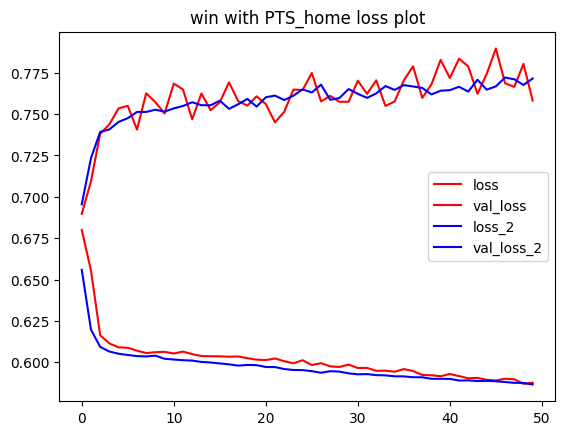

In [ ]:
plt.plot(r.history['loss'], label = 'loss', color = 'red')
plt.plot(r.history['val_loss'], label = 'val_loss', color = 'blue')
"""
plt.plot(r_2.history['loss'], label = 'loss_2', color = 'blue')
plt.plot(r_2.history['val_loss'], label = 'val_loss_2', color = 'blue')
"""
plt.title('win with ' + feature + ' loss plot')
plt.legend()

"""
filename_loss = '/content/win_loss_plot-' + feature + '.png'
plt.savefig(filename_loss, format = 'png')
"""

In [ ]:
#SPRAWDZANIE DOPASOWANIA WARSTW DO DANYCH
"""
1 warstwa Dense lepszy dla:
PTS_home
FG_PCT_home acc+ loss-
FG3_PCT_home
REB_home acc+
PTS_AWAY acc+
FT_PCT_AWAY acc+
"""

"""
liczba_wiekszych_loss = sum([1 for i in range(len(r.history['val_loss'])) if r_2.history['val_loss'][i] < r.history['val_loss'][i]])
liczba_wiekszych_acc = sum([1 for i in range(len(r.history['val_accuracy'])) if r_2.history['val_accuracy'][i] > r.history['val_accuracy'][i]])
a = True if liczba_wiekszych_loss > 25 else False
b = True if liczba_wiekszych_acc > 25 else False
print(f"epoki z wiekszym acc w modelu_2: {b}, loss mniejsze w modelu_2: {a}, dla modelu z cecha: {feature}")
"""

'\n1 warstwa Dense lepszy dla:\nPTS_home\nFG_PCT_home acc+ loss-\nFG3_PCT_home\nREB_home acc+\nPTS_AWAY acc+\nFT_PCT_AWAY acc+\n'

In [ ]:

"""
from google.colab import files

files.download(filename_acc)
files.download(filename_loss)
"""


'\nfrom google.colab import files\n\nfiles.download(filename_acc)\nfiles.download(filename_loss)\n'